# Anchor-Probe Hidden Distance
**Goal**: Analyze the distance between the hidden representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
all_anchors_data = []
all_probes_data = []

for dilution in range(1, 4):
    # Load anchors data
    anchors_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')
    anchors_data = anchors_data[anchors_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])].reset_index(drop=True)
    anchors_data['dilution'] = dilution

    # Load probes data
    probes_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-hidden.pkl')
    probes_data['dilution'] = dilution

    all_anchors_data.append(anchors_data)
    all_probes_data.append(probes_data)

all_anchors_data = pd.concat(all_anchors_data)
all_probes_data = pd.concat(all_probes_data)

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [3]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,1850,"[0.02357764, 0.09254456, 0.4413847, 0.4782121,...",0,slit,slit,ANC_REG,1
1,1850,"[0.9571533, 0.2817168, 0.03160163, 0.991742, 0...",1,thax,Tks,ANC_REG,1
2,1850,"[0.3521752, 0.7513624, 0.001733726, 0.9937267,...",2,kleef,klEf,ANC_REG,1
3,1850,"[0.01986267, 0.9182791, 0.1537067, 0.3663398, ...",3,krim,krim,ANC_REG,1
4,1850,"[0.9145361, 0.9304242, 0.7172889, 0.07215772, ...",4,nisp,nisp,ANC_REG,1


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [5]:
results = []
for dilution in [1, 2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_hidden = anchors_data[anchors_data['orth'].isin(row['anchor'])]
        probes_hidden = probes_data[probes_data['orth'].isin(row['probes'])]

        for epoch in anchor_hidden['epoch'].unique():
            epoch_anchor_hidden = np.array(anchor_hidden[anchor_hidden['epoch'] == epoch]['hidden'].tolist())
            epoch_probe_hidden = np.array(probes_hidden[probes_hidden['epoch'] == epoch]['hidden'].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                'anchor': row['anchor'],
                'probes': row['probes'],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_probe_hidden),
                'l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_probe_hidden)
            })

Dilution 3: 100%|██████████| 27/27 [00:05<00:00,  4.92it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', 'first_anchor']).reset_index(drop=True)

In [7]:
results_df.head()

,dilution,epoch,anchor,probes,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,1,1850,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.16882617248419507, 0.14526435669653115, 0....","[[28.440996495341004, 26.106071453099997, 25.5...",0.148552,26.193032,blome
1,2,1850,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.16882617248419507, 0.14526435669653115, 0....","[[28.440996495341004, 26.106071453099997, 25.5...",0.134580,24.640596,blome
2,3,1850,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.16882617248419507, 0.14526435669653115, 0....","[[28.440996495341004, 26.106071453099997, 25.5...",0.134310,24.891264,blome
3,1,1850,"[clead, smead, pread]","[glead, yead, jead, kead]",AMB,"[[0.0868239853627818, 0.20535964595880718, 0.1...","[[17.4271844033, 29.69534255389999, 25.5032253...",0.135891,22.815753,clead
4,2,1850,"[clead, smead, pread]","[glead, yead, jead, kead]",AMB,"[[0.08682398536278191, 0.2053596459588073, 0.1...","[[17.4271844033, 29.69534255389999, 25.5032253...",0.129100,22.328145,clead


## Mean Cosine and L1 Distance by Anchor/Probe Type

This first pair of graphs aggregate all three dilution levels together. The idea is that each anchor/probe set is weighted equally, and the dilution levels are weighted equally - i.e. each point of the curve is composed of 30 datapoints (3 dilution levels times 10 anchor sets) for REG/EXC and 21 datapoints for ambiguous.

The error bands are based on a confidence interval. The confidence interval being plotted is the 68% confidence interval - which approximately corresponds to standard error.

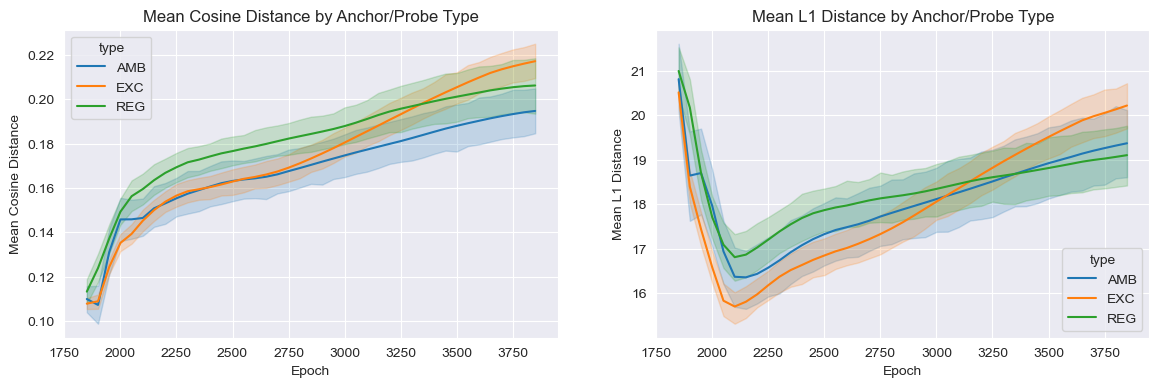

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Anchor/Probe Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Anchor/Probe Type')

plt.show()

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

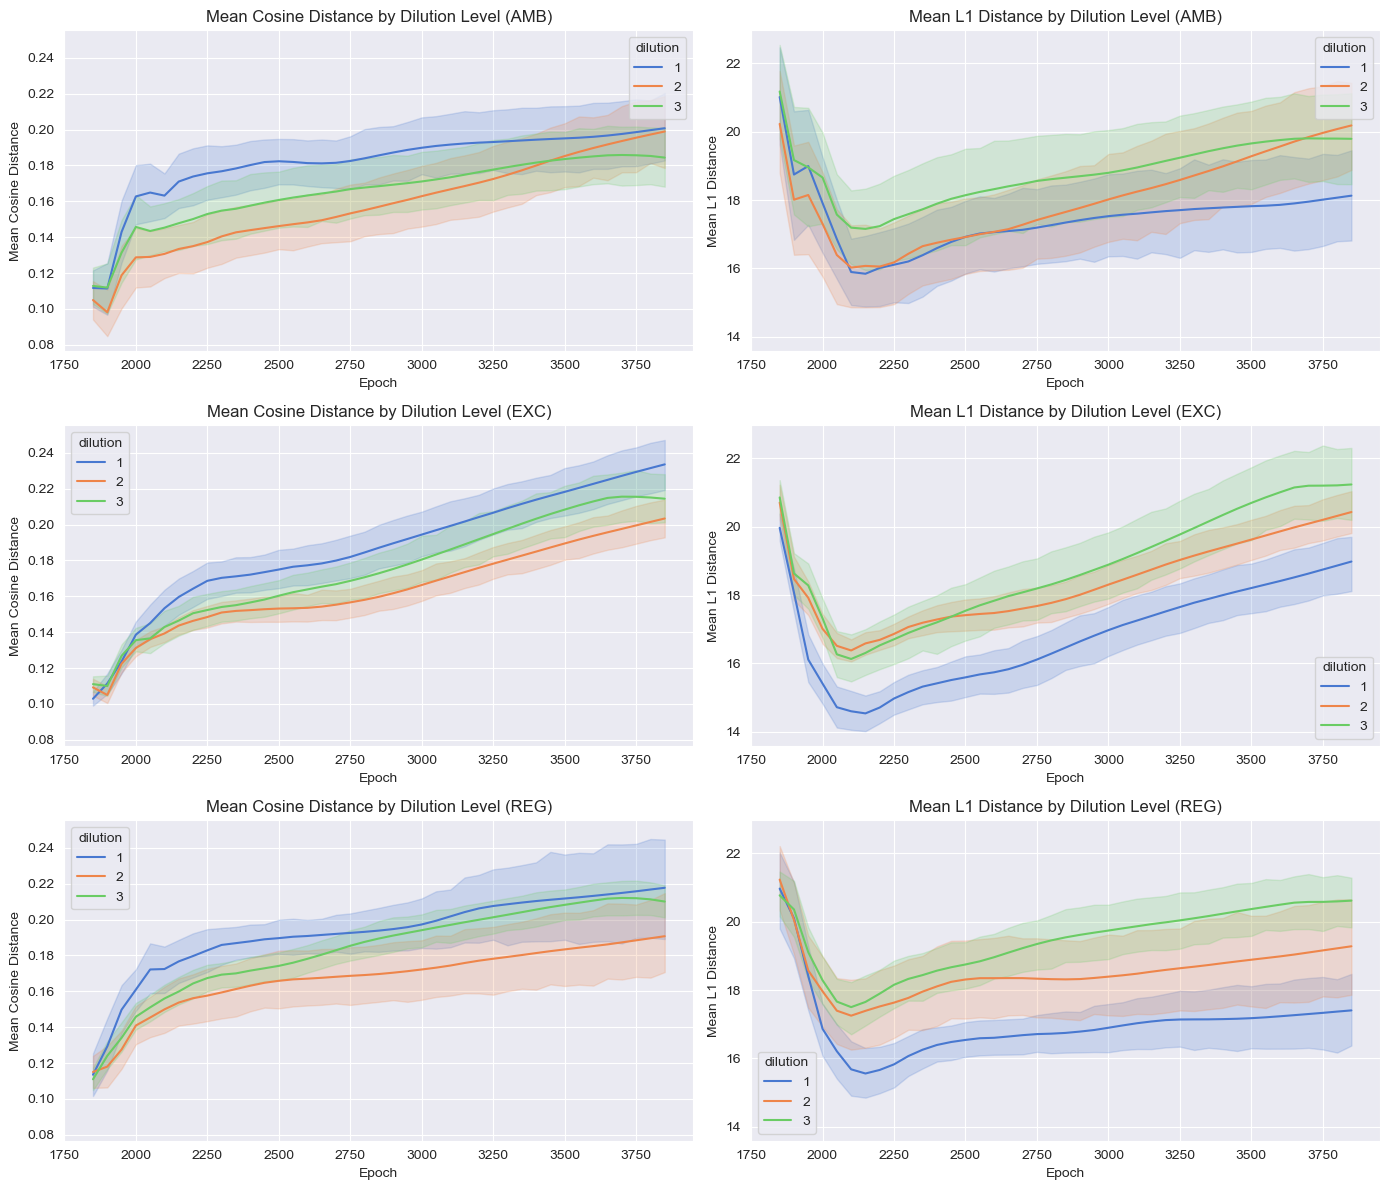

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

**Notes**
* It appears that training has not yet stabilized, as the curves are still increasing (this is especially evident for the exceptions).

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

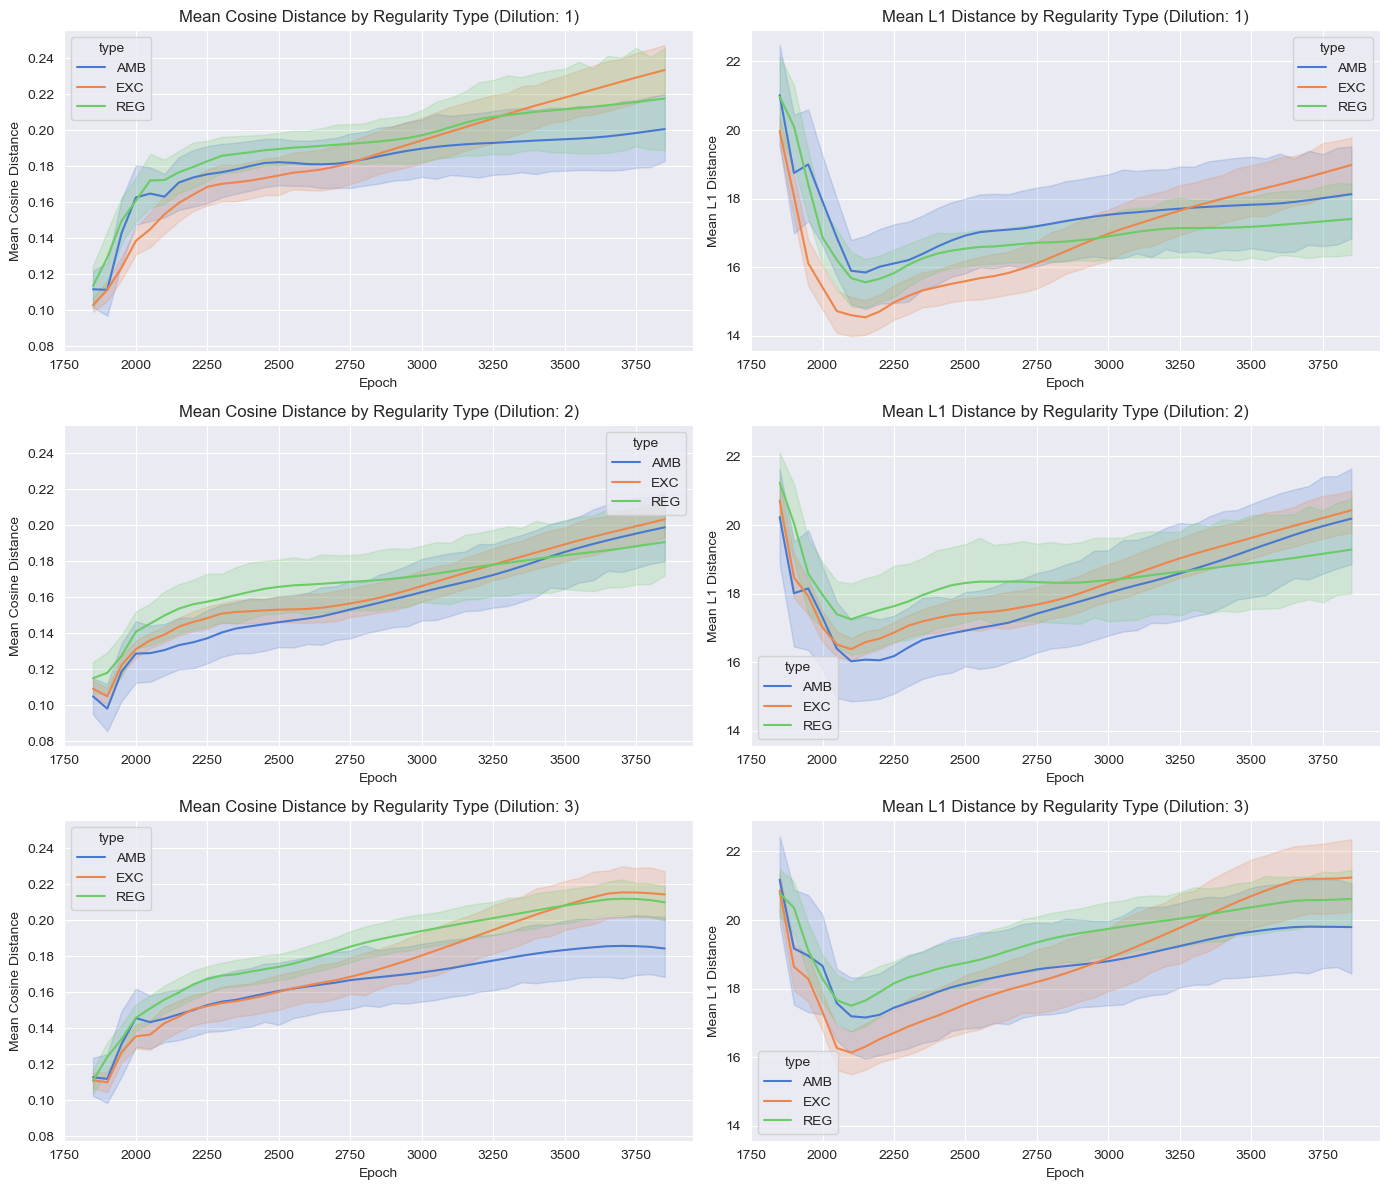

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Anchor-Probe Distance by Anchor
* We refer to each anchor/probe set by the first anchor.

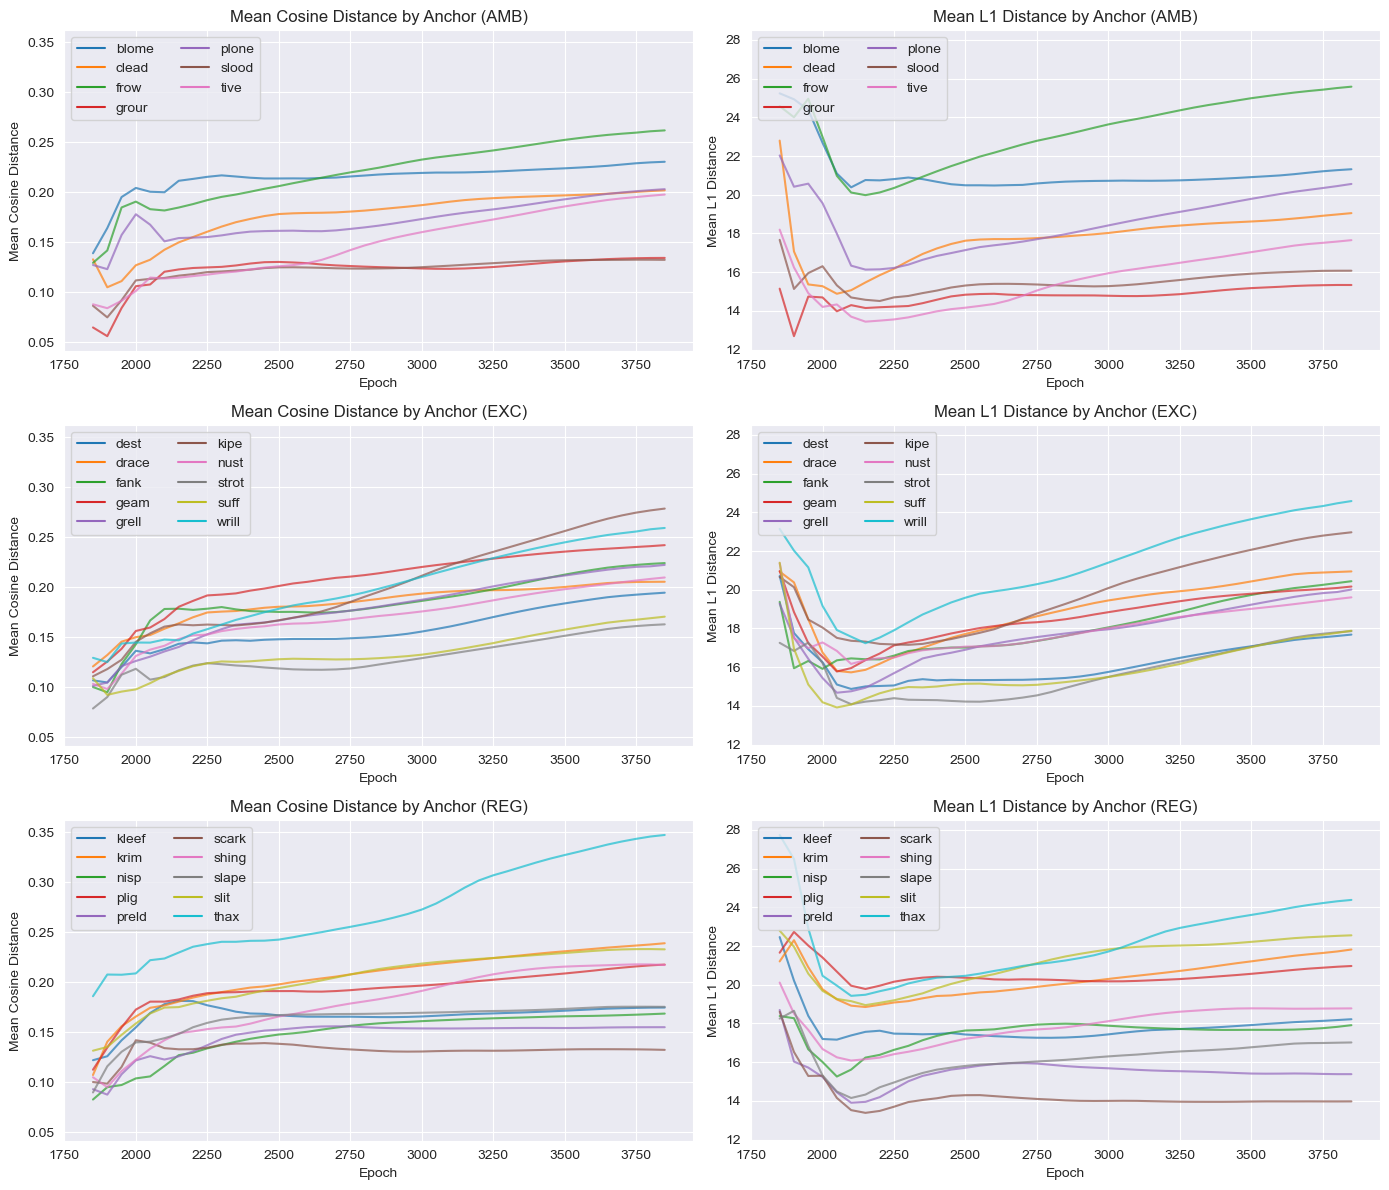

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Anchor ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Anchor ({word_type})')

plt.tight_layout()
plt.show()

**Notes**
* The anchor group for 'thax' is an outlier compared to the rest of the regular anchors (for the cosine distance metric). The mean cosine distance between 'thax' and its probes are much greater than the other regular anchor/probe sets.

## Removing the Outlier "thax"
The plots are the same as the ones before, except with the 'thax' anchor group removed.

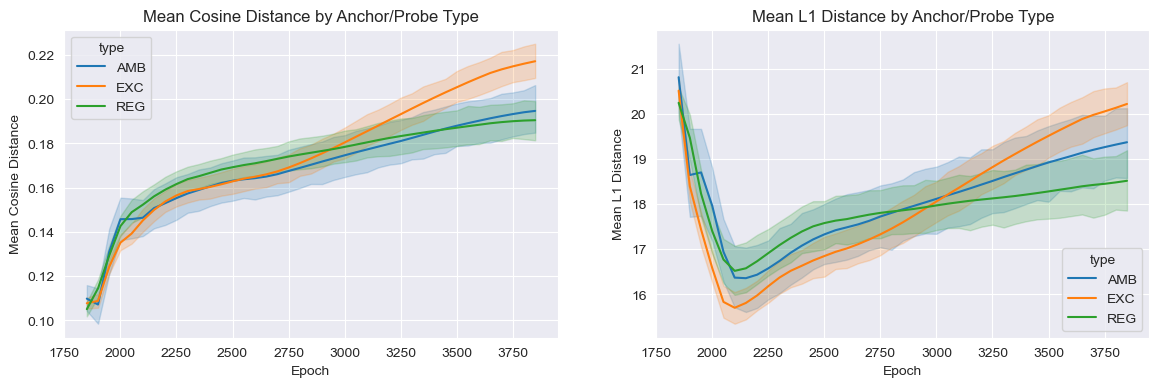

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df[results_df['first_anchor'] != 'thax'], x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Anchor/Probe Type')

sns.lineplot(data=results_df[results_df['first_anchor'] != 'thax'], x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Anchor/Probe Type')

plt.show()

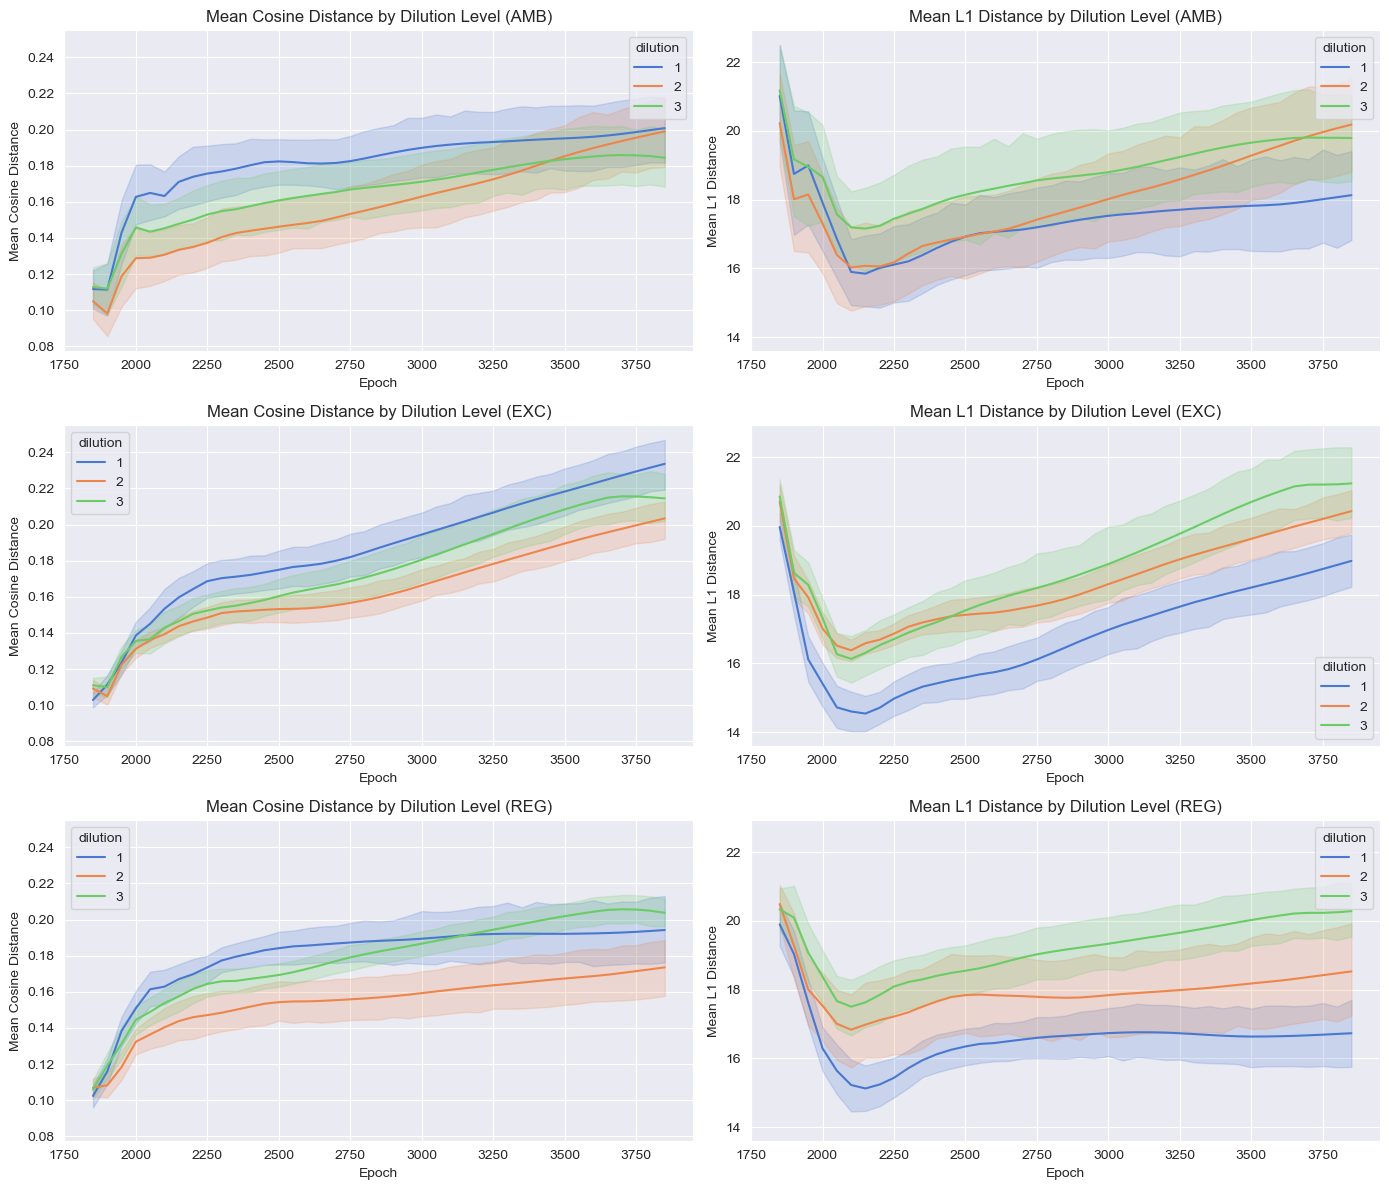

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[(results_df['first_anchor'] != 'thax') & (results_df['type'] == word_type)],
                 x='epoch', y='mean_cosine_distance', hue='dilution', ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[(results_df['first_anchor'] != 'thax') & (results_df['type'] == word_type)],
                 x='epoch', y='mean_l1_distance', hue='dilution', ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

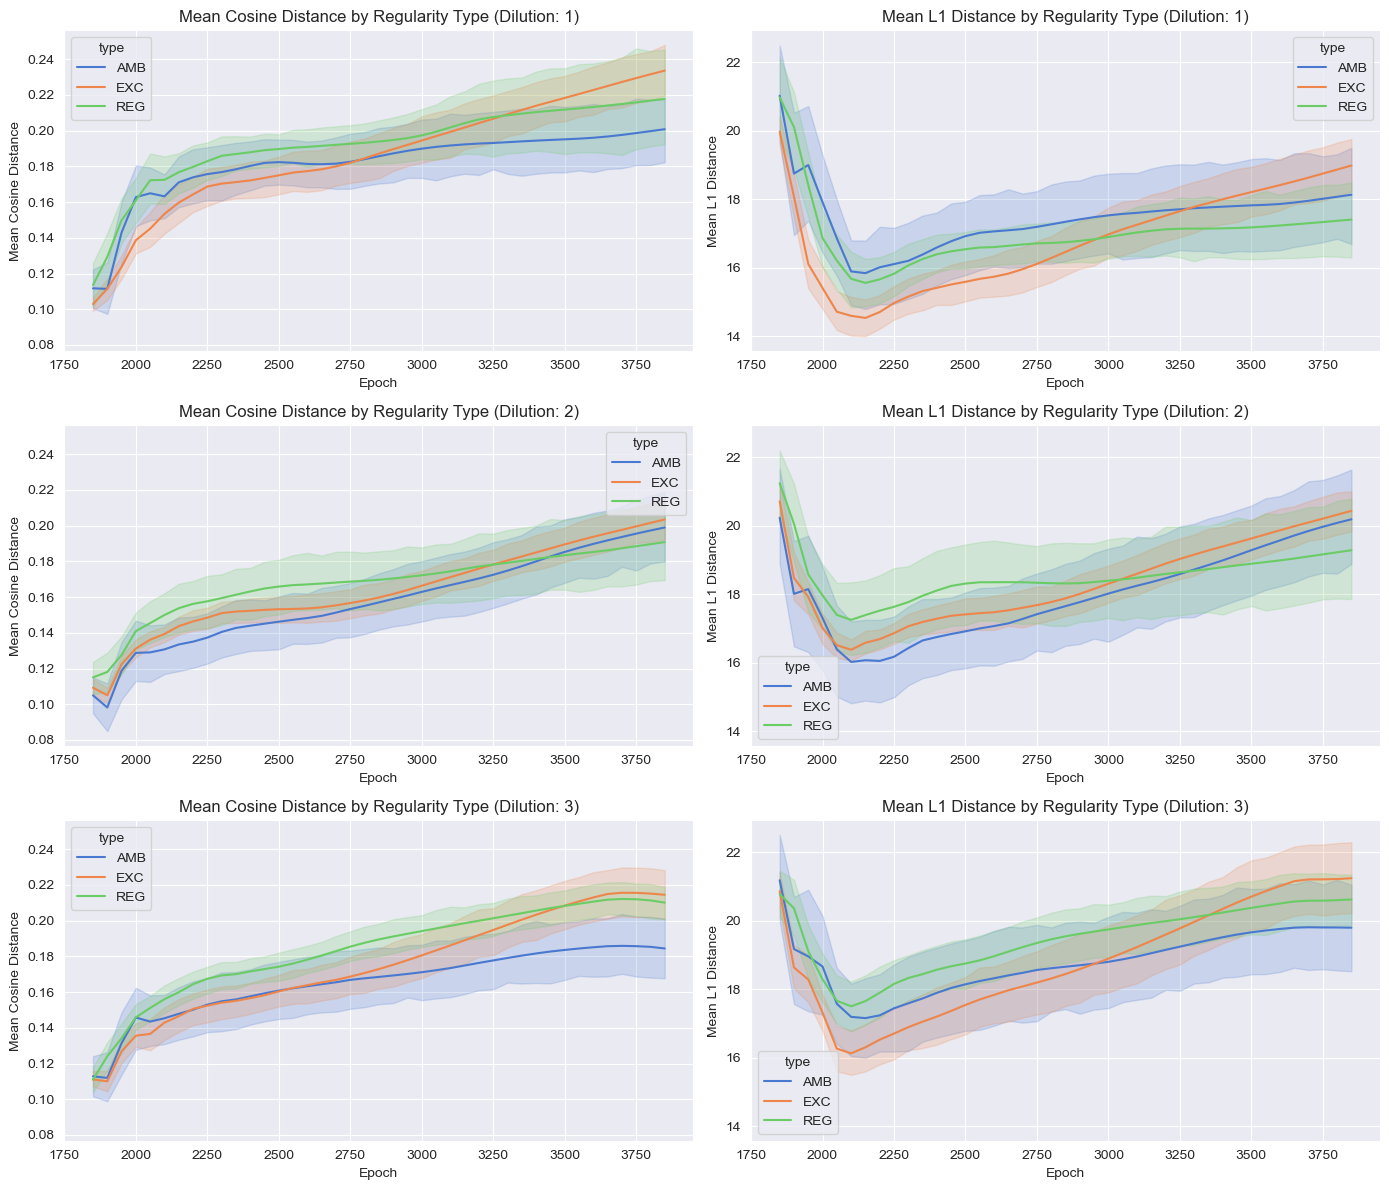

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()